# Import data from SQL database

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns; sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')
# %matplotlib inline
plt.rcParams.update({'figure.titlesize': 'larger', 'legend.fontsize': 15.0})

In [2]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, password =sqluser )
cur = con.cursor()

In [3]:
# Commands to run .sql file in CMD 

# psql "dbname=mimic user=postgres"
# \i all_data.sql 

In [4]:
# SQL query (gets all_data view defined elsewhere)
query = \
"""
select * from all_data
"""

# Perform SQL query
cur.execute('SET search_path to ' + schema_name)
data = pd.read_sql_query(query,con)

In [5]:
data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,dod,first_careunit,last_careunit,age,gender,...,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,sapsii,sofa,urine_min,urine_mean,urine_max
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,2102-06-14,MICU,MICU,76.526788,M,...,103.0,58.64,35.222223,37.666668,36.85,79,7,5.0,143.0,600.0
1,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaT,SICU,SICU,65.940670,F,...,88.0,60.01,35.611110,37.444445,36.56,24,4,20.0,81.0,200.0
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,2149-11-14,MICU,MICU,41.790226,M,...,194.0,76.73,34.888891,37.888887,36.47,31,5,10.0,148.0,1100.0
3,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,2104-08-20,SICU,SICU,72.372364,M,...,111.0,72.41,35.500001,38.500002,37.24,41,3,30.0,172.0,540.0
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,NaT,CCU,CSRU,39.866116,F,...,90.0,65.22,35.944443,38.599998,37.48,13,1,30.0,98.0,260.0


# Testing query for more concepts

### newly added to all_data

- PATIENTS:  `DOD`
- ELIXHAUSER_AHRQ_SCORE : `elixhauser_vanwalraven`, `elixhauser_sid29`, `elixhauser_sid30`
- admissions: `admission_type`, `admission_location`,    `discharge_location`, `ethnicity`, `diagnosis`
- icustay_detail: `los_hospital`
- vitalsfirstday: `meanbp_min`, `meanbp_max`, `meanbp_mean`, `spo2_min`, `spo2_max`,`spo2_mean`
- ventfirstday : `vent`
- rrtfirstday: `rrt`
- uofirstday: `urineoutput`
- LODS: `lods`
- SIRS: `sirs`

- sepsis: NOT SURE ABOUT THIS ONE 

In [11]:
new_quey = \
"""
set search_path to mimiciii;

    select all_data.*
        , elixhauser_vanwalraven, elixhauser_sid29, elixhauser_sid30
        , los_hospital
        , meanbp_min, meanbp_max, meanbp_mean, spo2_min, spo2_max,spo2_mean



    from all_data

        left join 
            (select 
                eas.hadm_id, eas.elixhauser_vanwalraven, eas.elixhauser_sid29, eas.elixhauser_sid30
            from 
                ELIXHAUSER_AHRQ_SCORE eas
                ) eas_p
        on all_data.hadm_id = eas_p.hadm_id

        left join 
            (select distinct
                icd.hadm_id, icd.los_hospital
            from 
                icustay_detail icd
                ) icd_p
        on all_data.hadm_id = icd_p.hadm_id          

        left join 
            (select distinct
                vfd.hadm_id, vfd.meanbp_min, vfd.meanbp_max, vfd.meanbp_mean,
                vfd.spo2_min, vfd.spo2_max, vfd.spo2_mean
            from
                vitalsfirstday  vfd
                ) vfd_p
        on all_data.hadm_id = vfd_p.hadm_id


"""
checking = pd.read_sql_query(new_quey, con)

In [12]:
checking

,subject_id,hadm_id,admittime,dischtime,deathtime,dod,first_careunit,last_careunit,age,gender,...,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30,los_hospital,meanbp_min,meanbp_max,meanbp_mean,spo2_min,spo2_max,spo2_mean
0,54610,100003,2150-04-17 15:34:00,2150-04-21 17:30:00,NaT,2150-12-28,MICU,MICU,59.912739,M,...,11,5,7,4.0806,47.000000,97.000,70.031250,87.0,100.0,98.281250
1,9895,100006,2108-04-06 15:49:00,2108-04-18 17:18:00,NaT,2109-10-24,MICU,MICU,48.917318,F,...,11,11,22,12.0618,77.333298,107.000,88.405796,94.0,100.0,97.880000
2,23018,100007,2145-03-31 05:33:00,2145-04-07 12:40:00,NaT,NaT,SICU,TSICU,73.822921,F,...,0,0,0,7.2965,63.000000,101.000,87.878788,98.0,100.0,99.823529
3,533,100009,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,NaT,CSRU,CSRU,60.797126,M,...,-4,-1,-1,4.9035,61.000000,79.000,69.958333,91.0,100.0,97.090909
4,55853,100010,2109-12-10 07:15:00,2109-12-14 16:45:00,NaT,NaT,SICU,SICU,54.520844,F,...,5,9,11,4.3958,35.000000,150.000,67.770833,93.0,100.0,99.166667
5,87977,100011,2177-08-29 04:51:00,2177-09-12 14:24:00,NaT,NaT,TSICU,TSICU,21.504104,M,...,-7,-8,-11,14.3979,59.000000,105.000,81.219512,96.0,100.0,99.657143
6,60039,100012,2177-03-12 11:48:00,2177-03-22 14:30:00,NaT,NaT,CSRU,CSRU,67.712617,M,...,0,0,0,10.1125,63.000000,104.000,73.344828,96.0,100.0,99.642857
7,68591,100016,2188-05-24 13:06:00,2188-05-30 17:16:00,NaT,2188-07-06,MICU,MICU,55.512635,M,...,6,4,5,6.1736,57.000000,111.000,73.521739,94.0,100.0,97.680000
8,16229,100017,2103-03-11 00:54:00,2103-03-11 17:31:00,NaT,NaT,MICU,MICU,27.329928,M,...,-2,-3,-6,0.6924,65.000000,107.667,83.727300,95.0,100.0,97.818182
9,58128,100018,2176-08-29 10:30:00,2176-09-06 17:13:00,NaT,2177-09-28,SICU,SICU,55.542455,M,...,18,26,36,8.2799,62.000000,95.000,79.760000,97.0,100.0,98.440000


In [13]:
new_new_quey = \
"""
set search_path to mimiciii;

            (select distinct
                vfd.hadm_id, vfd.meanbp_min, vfd.meanbp_max, vfd.meanbp_mean,
                vfd.spo2_min, vfd.spo2_max, vfd.spo2_mean
            from
                vitalsfirstday  vfd
                )

   
"""
new_checking = pd.read_sql_query(new_new_quey, con)
new_checking

,hadm_id,meanbp_min,meanbp_max,meanbp_mean,spo2_min,spo2_max,spo2_mean
0,100001,75.000000,127.000000,110.545455,96.0,100.0,97.833333
1,100003,47.000000,97.000000,70.031250,87.0,100.0,98.281250
2,100006,77.333298,107.000000,88.405796,94.0,100.0,97.880000
3,100007,63.000000,101.000000,87.878788,98.0,100.0,99.823529
4,100009,61.000000,79.000000,69.958333,91.0,100.0,97.090909
5,100010,35.000000,150.000000,67.770833,93.0,100.0,99.166667
6,100011,59.000000,105.000000,81.219512,96.0,100.0,99.657143
7,100012,63.000000,104.000000,73.344828,96.0,100.0,99.642857
8,100016,57.000000,111.000000,73.521739,94.0,100.0,97.680000
9,100017,65.000000,107.667000,83.727300,95.0,100.0,97.818182


In [19]:
len(new_checking.hadm_id.unique())

57328

In [30]:
pd.merge(checking, new_checking, left_on=checking.hadm_id, right_on= new_checking.hadm_id, how ='inner')

,key_0,subject_id,hadm_id_x,admittime,dischtime,deathtime,dod,first_careunit,last_careunit,age,...,temp_min,temp_max,temp_mean,sapsii,sofa,urine_min,urine_mean,urine_max,hadm_id_y,los_hospital
0,145834,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,2102-06-14,MICU,MICU,76.526788,...,35.222223,37.666668,36.85,79,7,5.0,143.0,600.0,145834,10.7847
1,107064,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaT,SICU,SICU,65.940670,...,35.611110,37.444445,36.56,24,4,20.0,81.0,200.0,107064,16.3646
2,150750,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,2149-11-14,MICU,MICU,41.790226,...,34.888891,37.888887,36.47,31,5,10.0,148.0,1100.0,150750,4.8813
3,112213,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,2104-08-20,SICU,SICU,72.372364,...,35.500001,38.500002,37.24,41,3,30.0,172.0,540.0,112213,12.6958
4,143045,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,NaT,CCU,CSRU,39.866116,...,35.944443,38.599998,37.48,13,1,30.0,98.0,260.0,143045,6.8556
5,194023,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,NaT,NaT,CSRU,CSRU,47.454296,...,36.000002,38.000001,36.75,53,7,5.0,42.0,150.0,194023,4.3681
6,161087,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaT,NaT,CSRU,CSRU,47.819229,...,36.599998,38.200001,37.33,21,2,30.0,104.0,360.0,161087,4.0201
7,157681,20,157681,2183-04-28 09:45:00,2183-05-03 14:45:00,NaT,NaT,CSRU,CSRU,75.876833,...,35.900002,37.299999,36.55,29,4,28.0,117.0,450.0,157681,5.2083
8,109451,21,109451,2134-09-11 12:17:00,2134-09-24 16:15:00,NaT,2135-02-08,CCU,CCU,87.439319,...,35.166668,37.444445,36.36,66,7,0.0,12.0,300.0,109451,13.1653
9,111970,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,2135-02-08,MICU,MICU,87.826340,...,35.722224,37.944446,36.65,56,7,0.0,11.0,175.0,111970,8.2208


# Preliminary statistics

In [4]:
# store the data into csv
data.to_csv('data.csv',index=False)

In [5]:
data.shape

(57996, 44)

In [6]:
print ('Number of unique patient ids: {}'.format(len(data.subject_id.unique())))

Number of unique patient ids: 34005


## Describe numerical data 

In [7]:
data[['age','sapsii','sofa']].describe()

,age,sapsii,sofa
count,57996.000000,57996.000000,57996.000000
mean,75.415010,36.797400,4.556797
std,53.924155,14.494745,3.241760
min,14.911113,0.000000,0.000000
25%,54.070590,27.000000,2.000000
50%,66.827321,35.000000,4.000000
75%,78.174955,45.000000,6.000000
max,310.280859,118.000000,22.000000


In [8]:
data.loc[data.age<300].age.describe()

count    55099.000000
mean        63.580520
std         16.022694
min         14.911113
25%         53.328980
50%         65.703551
75%         76.578615
max         89.003531
Name: age, dtype: float64

In [9]:
data[['resprate_min', 'resprate_max', 'resprate_mean',]].describe()

,resprate_min,resprate_max,resprate_mean
count,57981.000000,57981.000000,57981.000000
mean,9.782119,32.962557,19.375751
std,3.727347,9.072195,3.539746
min,0.170000,8.000000,7.333333
25%,7.000000,26.000000,16.846774
50%,10.000000,31.000000,19.040404
75%,12.000000,38.000000,21.526316
max,33.000000,69.000000,43.777778


In [10]:
data[['urea_n_min','urea_n_mean','urea_n_max',]].describe()

,urea_n_min,urea_n_mean,urea_n_max
count,57963.000000,57963.000000,57963.000000
mean,16.463710,27.333612,42.224557
std,13.314368,18.915366,31.176981
min,0.000000,1.421053,2.000000
25%,9.000000,14.500000,20.000000
50%,13.000000,21.285714,31.000000
75%,19.000000,34.500000,55.000000
max,161.000000,232.040000,290.000000


In [11]:
data[['magnesium_max','albumin_min','calcium_min']].describe()

,magnesium_max,albumin_min,calcium_min
count,57548.000000,41367.000000,56248.000000
mean,2.501767,2.799359,7.673363
std,1.012201,0.757489,0.863674
min,0.400000,0.900000,0.000000
25%,2.200000,2.200000,7.200000
50%,2.400000,2.700000,7.700000
75%,2.700000,3.300000,8.200000
max,58.000000,5.700000,17.900000


In [12]:
data[['glucose_min','glucose_mean','glucose_max']].describe()

,glucose_min,glucose_mean,glucose_max
count,57638.000000,57638.000000,57638.000000
mean,86.977461,137.750363,271.053735
std,30.178478,86.866399,5961.165184
min,0.106000,21.000000,21.000000
25%,70.000000,117.142857,157.000000
50%,86.000000,130.800000,197.000000
75%,101.000000,149.946429,265.000000
max,485.000000,17994.482143,999999.000000


In [13]:
data[['hr_min','hr_mean','hr_max']].describe()

,hr_min,hr_mean,hr_max
count,57994.000000,57994.000000,57994.000000
mean,62.747368,85.759691,118.006071
std,14.767748,13.134256,25.515820
min,0.350000,34.710000,39.000000
25%,54.000000,76.770000,99.000000
50%,63.000000,85.140000,116.000000
75%,72.000000,94.430000,134.000000
max,141.000000,163.880000,285.000000


In [14]:
data[['sysbp_min','sysbp_mean','sysbp_max']].describe()

,sysbp_min,sysbp_mean,sysbp_max
count,57988.000000,57988.000000,57988.000000
mean,79.984309,120.333388,165.783576
std,21.150334,15.593030,28.935278
min,0.060000,29.170000,45.000000
25%,70.000000,109.130000,145.000000
50%,81.000000,118.670000,162.000000
75%,93.000000,130.192500,183.000000
max,181.000000,215.830000,355.000000


In [15]:
data[['diasbp_min','diasbp_mean','diasbp_max']].describe()

,diasbp_min,diasbp_mean,diasbp_max
count,57988.00000,57988.000000,57988.000000
mean,35.72244,60.253103,99.736583
std,12.31615,9.708390,27.585497
min,0.32000,14.500000,25.000000
25%,27.00000,53.657500,82.000000
50%,36.00000,59.300000,95.000000
75%,44.00000,66.060000,111.000000
max,105.00000,117.870000,298.000000


In [16]:
data[['temp_min','temp_mean','temp_max']].describe()

,temp_min,temp_mean,temp_max
count,57907.000000,57907.000000,57907.000000
mean,35.625338,36.848842,37.977907
std,0.919910,0.527247,0.882785
min,15.000000,30.000000,30.000000
25%,35.277778,36.530000,37.333333
50%,35.666667,36.830000,37.888889
75%,36.111111,37.170000,38.500002
max,40.000000,40.120000,46.500000


In [17]:
data[['urine_min','urine_mean','urine_max']].describe()

,urine_min,urine_mean,urine_max
count,57985.000000,57985.000000,5.798500e+04
mean,25.898059,126.103510,6.679872e+02
std,62.026718,537.055435,1.935803e+04
min,0.000000,0.000000,0.000000e+00
25%,0.000000,77.000000,3.000000e+02
50%,15.000000,110.000000,4.500000e+02
75%,30.000000,149.000000,6.500000e+02
max,3100.000000,119965.000000,4.555555e+06


In [18]:
data[['platelets_min','platelets_mean','platelets_max']].describe()

,platelets_min,platelets_mean,platelets_max
count,57953.000000,57953.000000,57953.000000
mean,158.938562,238.752800,353.653012
std,93.330341,117.351249,195.654320
min,4.000000,9.562500,12.000000
25%,98.000000,161.750000,224.000000
50%,148.000000,221.448276,309.000000
75%,207.000000,296.000000,434.000000
max,1328.000000,1551.387097,2813.000000


## Describe categorical data 

In [19]:
data.gender.value_counts(dropna=False)

M    32392
F    25604
Name: gender, dtype: int64

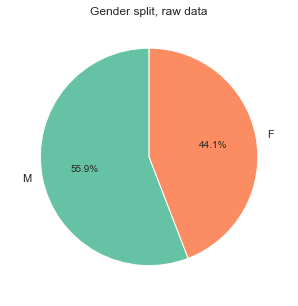

In [20]:
fig = plt.figure(figsize=(5,5))
data.gender.value_counts(dropna=False).plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Gender split, raw data')
plt.ylabel('')
# plt.savefig('figures/raw_gender.png')
plt.show()

In [21]:
data.marital_status.value_counts(dropna=False)

MARRIED              27989
SINGLE               14024
WIDOWED               8304
DIVORCED              3821
NaN                   2826
SEPARATED              616
UNKNOWN (DEFAULT)      400
LIFE PARTNER            16
Name: marital_status, dtype: int64

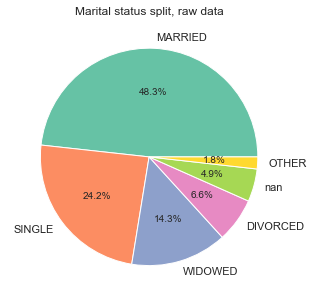

In [22]:
# reorganize for better plotting 
plotting = (data.marital_status.value_counts(dropna=False))
plotting['OTHER'] = plotting['UNKNOWN (DEFAULT)'] + plotting['LIFE PARTNER'] + plotting['SEPARATED']
plotting = plotting.drop(['UNKNOWN (DEFAULT)', 'LIFE PARTNER', 'SEPARATED'])
plotting

fig = plt.figure(figsize=(5,5))
plotting.plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_marital.png')
plt.show()

In [23]:
data.insurance.value_counts(dropna=False)

Medicare      33146
Private       18074
Medicaid       4883
Government     1371
Self Pay        522
Name: insurance, dtype: int64

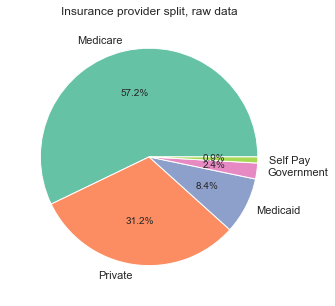

In [24]:
fig = plt.figure(figsize=(5,5))
data.insurance.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Insurance provider split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_insurance.png')
plt.show()

In [25]:
data.first_careunit.value_counts(dropna=False)

MICU     20431
CSRU     10857
SICU     10777
CCU       8167
TSICU     7764
Name: first_careunit, dtype: int64

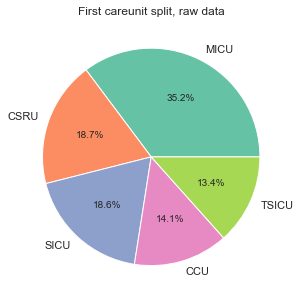

In [26]:
fig = plt.figure(figsize=(5,5))
data.first_careunit.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('First careunit split, raw data')
plt.ylabel('')
# fig.savefig('figures/raw_insurance.png')
plt.show()

In [27]:
data.last_careunit.value_counts(dropna=False)

MICU     20853
SICU     11277
CSRU     10862
CCU       7670
TSICU     7334
Name: last_careunit, dtype: int64

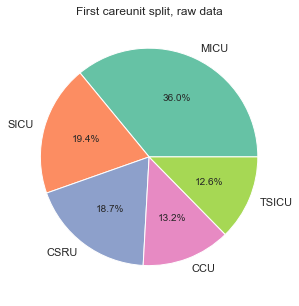

In [28]:
fig = plt.figure(figsize=(5,5))
data.last_careunit.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('First careunit split, raw data')
plt.ylabel('')
plt.show()

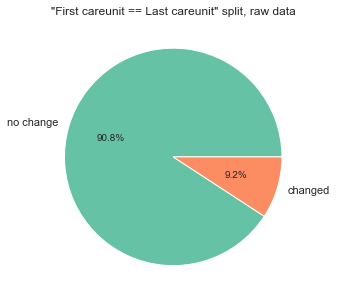

In [29]:
plotting = pd.Series(np.where(data.first_careunit == data.last_careunit, 'no change', 'changed'))
fig = plt.figure(figsize=(5,5))
plotting.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('"First careunit == Last careunit" split, raw data')
plt.ylabel('')
plt.show()

In [30]:
data.dod.describe()

count                   28655
unique                  11865
top       2191-04-07 00:00:00
freq                      107
first     2100-08-19 00:00:00
last      2211-06-10 00:00:00
Name: dod, dtype: object

## Check the missing data 

In [31]:
np.sum(data.isnull())

subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime         48877
dod               29341
first_careunit        0
last_careunit         0
age                   0
gender                0
marital_status     2826
insurance             0
urea_n_min           33
urea_n_max           33
urea_n_mean          33
platelets_min        43
platelets_max        43
platelets_mean       43
magnesium_max       448
albumin_min       16629
calcium_min        1748
resprate_min         15
resprate_max         15
resprate_mean        15
glucose_min         358
glucose_max         358
glucose_mean        358
hr_min                2
hr_max                2
hr_mean               2
sysbp_min             8
sysbp_max             8
sysbp_mean            8
diasbp_min            8
diasbp_max            8
diasbp_mean           8
temp_min             89
temp_max             89
temp_mean            89
sapsii                0
sofa                  0
urine_min       

# Define label: die with 30 days or 1 year

In [32]:
# construct label: when the patient die
data.deathtime  = data.deathtime.combine_first(data.dod)  # merge DOD into deathtime 
data[['admittime','dod', 'deathtime']]
data['time_before_death'] = data.deathtime-data.admittime  # claculate time before death
data['time_before_death'].fillna(timedelta(days=400)) # fill NaN with 400 days, which means they did not die

data['thirty_days'] = np.where(data['time_before_death'] <= timedelta(days=30), 1, 0) # if die within 30 days, 1
data['one_year'] = np.where(data['time_before_death'] <= timedelta(days=365), 1, 0) # if die within 1 year, 1 

In [33]:
data.thirty_days.value_counts(dropna=False)  # imbalanced data set 

0    49225
1     8771
Name: thirty_days, dtype: int64

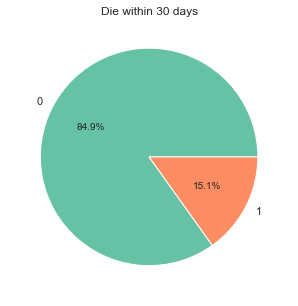

In [34]:
fig = plt.figure(figsize=(5,5))
data.thirty_days.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Die within 30 days')
plt.ylabel('')
plt.show()

In [35]:
data.one_year.value_counts(dropna=False)  # not too imbalanced

0    38643
1    19353
Name: one_year, dtype: int64

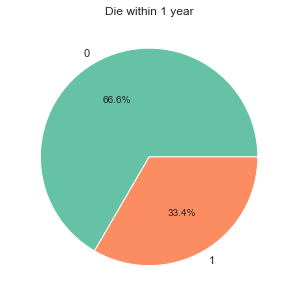

In [36]:
fig = plt.figure(figsize=(5,5))
data.one_year.value_counts(dropna=False).plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Die within 1 year')
plt.ylabel('')
plt.show()

# Correlation heatmap for all numerical columns

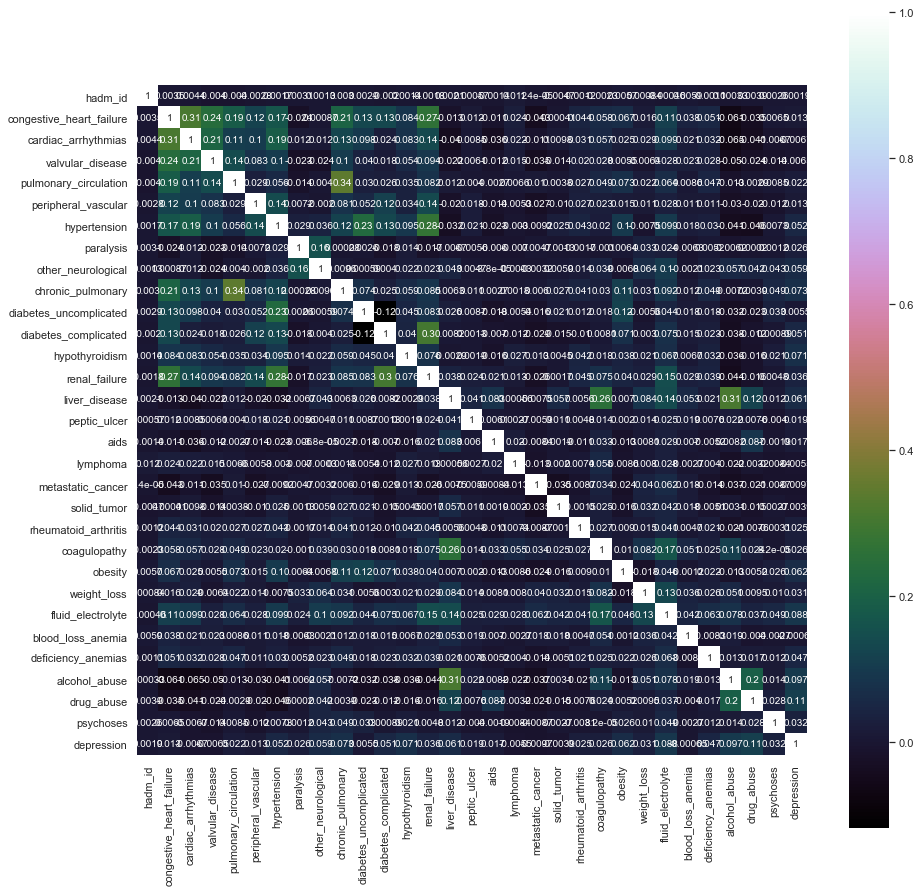

In [66]:
correlation = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

# TSNE

In [ ]:
def tsne(df):

    # df
    # run tsne
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(df.drop(columns=['catagory','PlayerID']).values)
    # plot 
    df_tsne = df.copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    

    # color by sequences
    chart1 = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='catagory') ) \
            + geom_point(size=75,alpha=0.8) \
            + ggtitle("tSNE dimensions colored by PlayerID")
#     # color by label
#     chart2 = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='PlayerID') ) \
#             + geom_point(size=75,alpha=0.8) \
#             + ggtitle("tSNE dimensions colored by LABEL")
    return chart1

In [49]:
# tsne(model_df.drop(columns=['GameID','Performance']))

### Save the labeled data into csv file 

In [37]:
# Save clean dataset to csv
data.to_csv('data_with_label.csv', index=False)